Let's start our Practical Session 2 : 


# Task 1

## Our first streaming using rate source


In [2]:
pip install pyspark

     |████████████████████████████████| 212.4 MB 67 kB/s 
     |████████████████████████████████| 198 kB 53.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=4f3c246c2fdd242020311e659acc553a39c7356895423ba7ebb1fb20273092d0
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


### Initialization SparkSession

In [1]:
import findspark
findspark.init("/opt/homebrew/Cellar/apache-spark/3.1.2/libexec/")

In [2]:
import pyspark
from pyspark.sql import SparkSession

In [3]:
spark = (SparkSession.builder.appName("Practical 3 Ahmed Azab").getOrCreate())

### Let’s first import the required libraries.

*   Pyspark functions 
*   Pyspark Types



In [4]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

### Create streaming DataFrame


Let’s create our first Spark Streaming DataFrame using rate source. Here we have specified the format as rate and specified rowsPerSecond = 1 to generate 1 row for each micro-batch and load the data into initDF streaming DataFrame. 

In [ ]:
initDF = (spark.readStream.format('rate')
         .option('rowsPerSecond',1)
         .load()
        )

### Check if DataFrame is streaming or Not.


In [ ]:
initDF.isStreaming

True

### Transformation

Perform transformation on initDF to generate another column result by just adding 1 to column value :


In [ ]:
outdf = initDF.withColumn("out", col("value") + 1)

### Output

In [ ]:
query = outdf.writeStream.outputMode("append").option("truncate", False).format("console").start()

In [ ]:
query.awaitTermination(timeout=5)

False

In [ ]:
query.stop()

### Create Streaming DataFrame using socket source. Also, check if DataFrame isStreaming.


In [ ]:
df2 = (spark.readStream.format('socket')
         .option('host','localhost')
         .option('port',12345)
         .load()
        )

In [ ]:
df2.isStreaming

True

### Transformation: Word Count


Here we count words from a stream of data coming from this socket. Also, we check the schema of our streaming DataFrame.


In [ ]:
word_count = df2.select(explode(split(col("value"),' ')).alias('words')).groupBy("words").count()

In [ ]:
word_count.printSchema()

root
 |-- words: string (nullable = true)
 |-- count: long (nullable = false)



# output


In [ ]:
quary = word_count.writeStream.outputMode("update").option("truncate", False).format("console").start()

In [ ]:
query.awaitTermination(timeout=35)

True

In [ ]:
query.stop()

### Input Sources — File

Schema Our data contains the fields Date,Open,High,Low,Close,Adj Close,Volume and we will extract Name from the filename using a custom function.
Here we define the schema and write a custom function to extract the stock ticker symbol.

In [ ]:
dfTogetSchema = spark.read.csv('/Users/ahmed/Downloads/Data 2/GE_2006-01-01_to_2018-01-01.csv', header=True, inferSchema=True)

In [ ]:
dfTogetSchema.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Name: string (nullable = true)



In [ ]:
recordSchema = dfTogetSchema.schema
recordSchema

StructType(List(StructField(Date,StringType,true),StructField(Open,DoubleType,true),StructField(High,DoubleType,true),StructField(Low,DoubleType,true),StructField(Close,DoubleType,true),StructField(Volume,IntegerType,true),StructField(Name,StringType,true)))

#### Create Streaming DataFrame


Create a streaming DataFrame to read csv data from a specified directory "data/stream" and apply the above schema . We also specify the param maxFilesPerTrigger = 2 , which means our application will process a maximum of 2 CSV files in each batch. At the end, we create another column called Name using the function getFileName. That column contains stock ticker symbols like GOOGL, AMZN, AAPL etc.

In [ ]:
df3 = (spark.readStream.format("csv").option("header",True).schema(recordSchema).option("maxFilesPerTrigger", 2)
      .load("/Users/ahmed/Downloads/read"))

In [ ]:
# ######### UDF Fun ##########

# def get_stockName(path):
#     x =  path.split("/")[-1]
    
#     y = x.split("_")[0]
    
#     return y 

# ############################

In [ ]:
# ######### test the fun ##################
# path = '/Users/ahmed/Downloads/Data 2/GE_2006-01-01_to_2018-01-01.csv'
# get_stockName(path)
# #########################################

In [ ]:
# get_stockNameUDF = udf(lambda z: get_stockName(z))


In [ ]:
# df4 = df3.withColumn("Name", get_stockNameUDF(input_file_name()))

In [ ]:
######### UDF Fun ##########

def get_year(date):
    return date.split("-")[0] 

############################
get_yearUDF = udf(lambda z: get_year(z))

In [ ]:
# test the fun 
######################
get_year('266-01-03')

'266'

In [ ]:
df_year = df3.withColumn("year", get_yearUDF(df3.Date))

In [ ]:
query = df_year.writeStream.outputMode("append") \
    .format("console") \
    .option("truncate", False) \
    .option("numRows", 10) \
    .start()

In [ ]:
query.awaitTermination(timeout=15)

False

In [ ]:
query.stop()

![Screen%20Shot%202021-10-10%20at%204.46.03%20PM.png](attachment:Screen%20Shot%202021-10-10%20at%204.46.03%20PM.png)

#### Transformation

Group the data based on stock Name, Year and find the maximum value of the HIGH column.

In [ ]:
df_new = df_year.groupby("Name","year").max("High")

In [ ]:
query = df_new.writeStream.outputMode("complete") \
    .format("console") \
    .option("truncate", False) \
    .option("numRows", 10) \
    .start()

In [ ]:
query.awaitTermination(timeout=35)

False

In [ ]:
query.stop()


![Screen%20Shot%202021-10-10%20at%204.45.52%20PM.png](attachment:Screen%20Shot%202021-10-10%20at%204.45.52%20PM.png)

Can you build same transformation by Sql? 

In [ ]:
df_year.createOrReplaceTempView("NAME_TABLE1")


In [ ]:
query = spark.sql("select Name,year, MAX(High) \
                  from NAME_TABLE1  GROUP BY Name,year").writeStream.outputMode("complete").format("console").option("truncate", False).queryName("NAME_TABLE1").start()

In [ ]:
query.awaitTermination(timeout=35)

False

In [ ]:
query.stop()


![Screen%20Shot%202021-10-10%20at%205.22.34%20PM.png](attachment:Screen%20Shot%202021-10-10%20at%205.22.34%20PM.png)

#### Output
Print the contents of streaming DatFrame to console using update mode.




Work with any dataset from data file 

In [ ]:
quary = word_count.writeStream.outputMode("update").option("truncate", False).format("console").start()

In [ ]:
query.awaitTermination(timeout=35)

In [ ]:
query.stop()

# Task 2

### Some aggregations transformation
Select "Name","Date", "Open", "High", "Low" and group by Name and Date and get the avg and use WithColumn to get current_timestamp 


In [ ]:
df4 = df_year.select("Name","Date", "Open", "High", "Low","year").groupBy(col("Name"), col("year")).agg(avg("year"))

### Checkpoints

In [ ]:
quary = df4.writeStream.outputMode("complete").option("checkpointlocation", 'checkpoint1').format("console").start()

In [ ]:
query.awaitTermination(timeout=35)

True

In [ ]:
query.stop()

# Task 3

### One-time micro-batch
With a once trigger, our query will execute a single micro-batch. It will process all available data and then stop the application. This trigger is useful when you would like to spin-up a cluster periodically, 
Execute our streaming application with the once trigger.

In [6]:
from pyspark import SparkContext
sc =SparkContext()

ValueError: ignored

In [ ]:
sc.addPyFile('/Users/ahmed/Downloads/graphframes-0.8.1-spark3.0-s_2.12.jar')

In [7]:
from graphframes import *

ModuleNotFoundError: ignored

In [ ]:
spark = (SparkSession.builder.appName("Practical 3 Ahmed Azab").getOrCreate())

### Users can create GraphFrames from vertex and edge DataFrames.

* Vertex DataFrame: A vertex DataFrame should contain a special column named “id” which specifies unique IDs for each vertex in the graph.
* Edge DataFrame: An edge DataFrame should contain two special columns: “src” (source vertex ID of edge) and “dst” (destination vertex ID of edge).

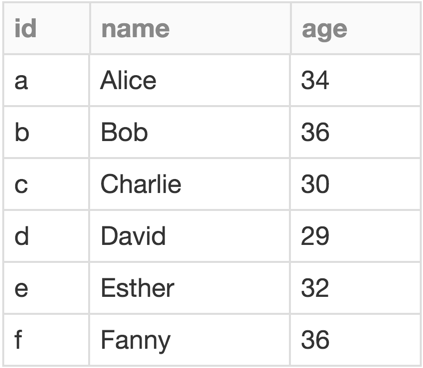

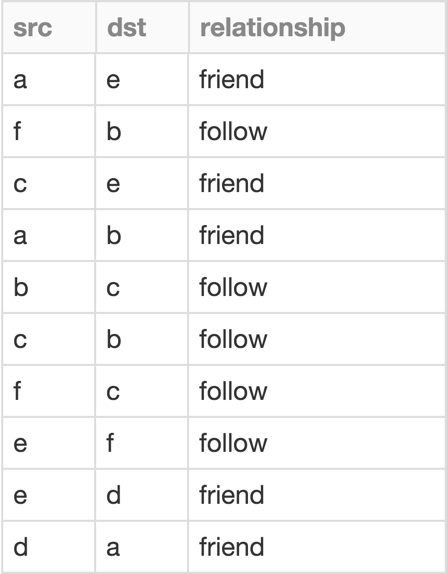

### Create a GraphFrame from vertex and edge DataFrames

In [5]:
v = spark.createDataFrame([
    ("a", "Alice", 34),
    ("b", "Bob", 36),
    ("c", "Charli", 30),
    ("d", "Davied", 29),
    ("e", "Esther", 32),
    ("e", "Fanny", 36),
], ["id","name","age"])

e = spark.createDataFrame([
    ("a", "e", "friend"),
    ("f", "b", "follow"),
    ("c", "e", "friend"),
    ("a", "b", "friend"),
    ("b", "c", "follow"),
    ("c", "b", "follow"),
    ("f", "c", "follow"),
    ("e", "f", "follow"),
    ("e", "d", "friend"),
    ("d", "a", "friend"),
], ["src","dst","relationship"])

### Take a look at the DataFrames

Get vertices, edges, and check the number of edges of each vertex

In [ ]:
!pyspark --packages graphframes:graphframes:0.8.1-spark3.0-s_2.12

Python 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
:: loading settings :: url = jar:file:/usr/local/lib/python3.7/dist-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-2cfd6b26-457b-4eba-88ba-82ef8e9e04a6;1.0
	confs: [default]
	found graphframes#graphframes;0.8.1-spark3.0-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 291ms :: artifacts dl 7ms
	:: modules in use:
	graphframes#graphframes;0.8.1-spark3.0-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules  

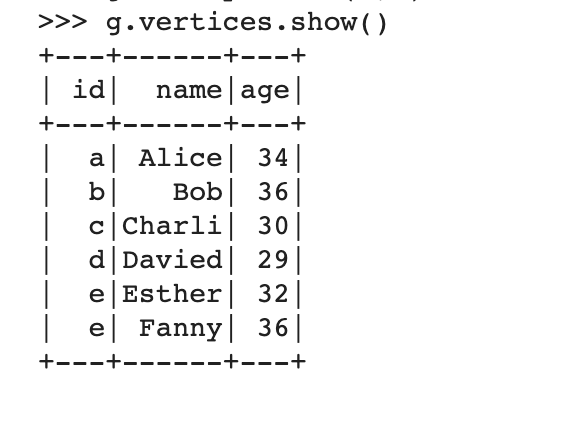

In [ ]:
g = GraphFrame(v,e)

## Create UDF Functions 
convert your graph by mapping a function over the edges DataFrame that deletes the row if src ≥ dst return "Delete" else "Keep"

In [11]:
from pyspark.sql.functions import *

def delet_keep(src, dst):
  if src>=dst:
    return "Delete"
  else :
    return "Keep"

delet_keep = lambda src, dst: "Delete" if (src>=dst) else "Keep"


delet_keepUDF = udf(lambda a,b: delet_keep(a,b))

In [ ]:
e1 = g.edges.withColumn("New", delet_keepUDF('src', 'dst'))

In [ ]:
e1.show()

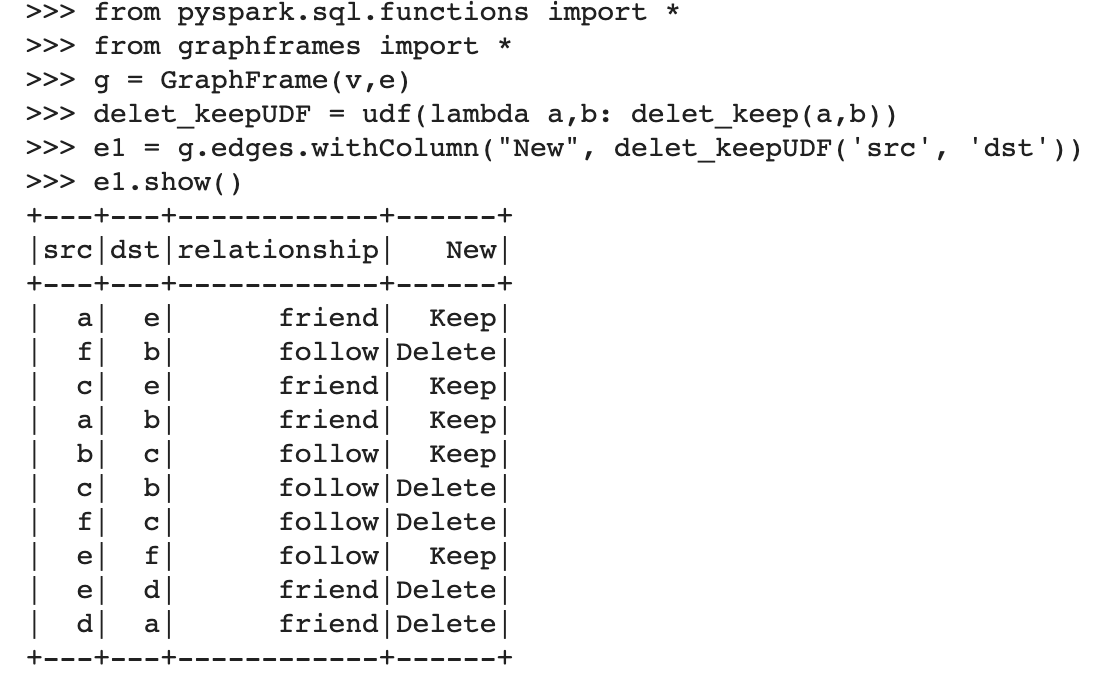

# Filtering and connected components

Check vertices when "age" greater than 30 and check edges "relationship" equal "friend" 

In [ ]:
g.vertices.filter('age > 30').show()

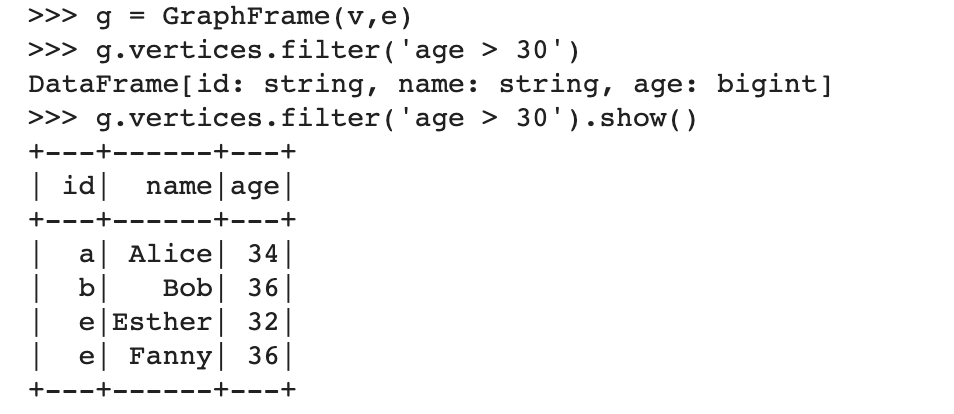

In [ ]:
g.edges.filter('relationship = "friend"').show()

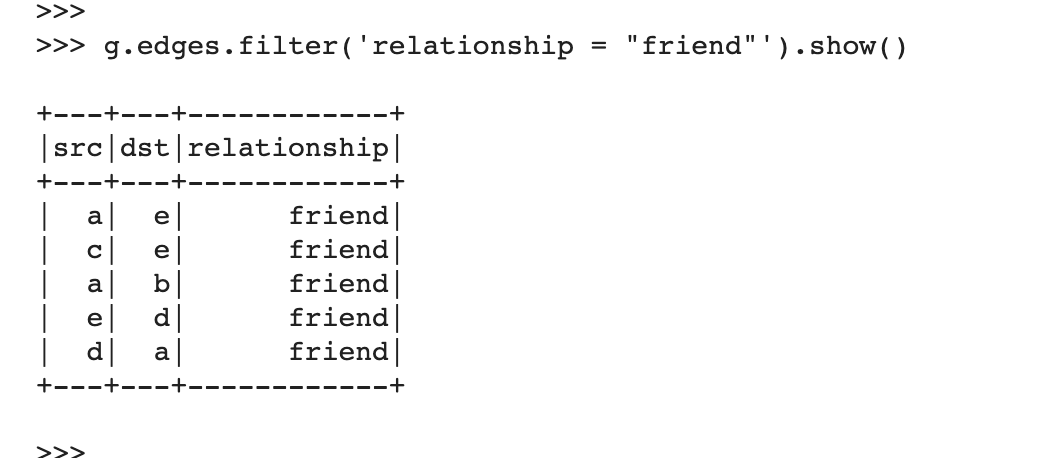

GraphFrames requires you to set a directory where it can save checkpoints. Create such a folder in your working directory 

In [ ]:
spark.sparkContext.setCheckpointDir("/home/azab/chkpointsdir")


Then, the connected components can easily be computed with the connectedComponents-function.


In [ ]:
result = g.connectedComponents()

In [ ]:
result.show()

## Motif finding


Search for pairs of vertices a,b connected by edge e and pairs of vertices b,c connected by edge e2. It will return a DataFrame of all such structures in the graph

In [ ]:
motifs_1 = g.find("(a)-[e]->(b); (b)-[e2]->(c)")
motifs_21.show()

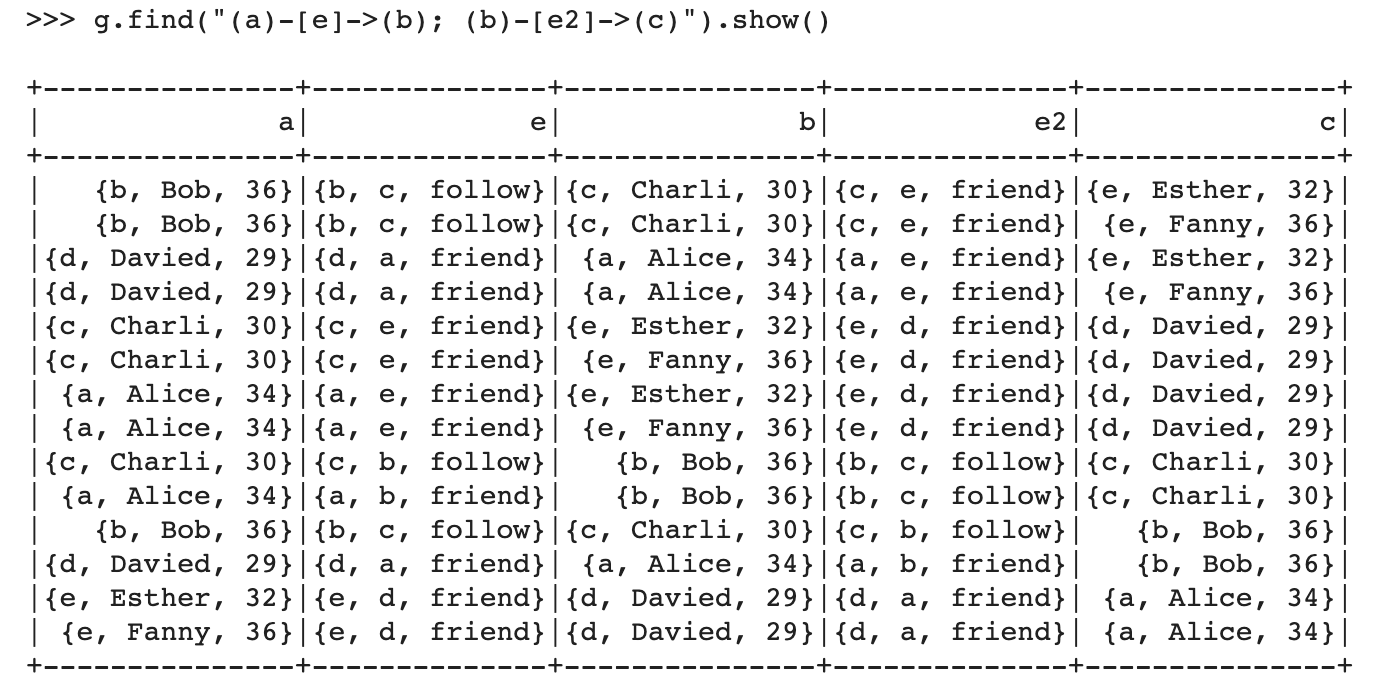